# Toy Example for `StratAge`

This notebook presents the logic and operation of `StratAge` on an example with completely synthetic toy data.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy import stats
import arviz as az
import pymc as pm

import stratage
from stratage.geochron import Geochron
import pystrat

import matplotlib.pyplot as plt

## Synthetic stratigraphy

Here let's fabricate a synthetic stratigraphy with five units and three geochronologic constraints. We also construct an age model in the `times` array, which contains the bottom and top ages for each unit. This is the true age model that `StratAge` will recover probabilistically.

In [2]:
units = np.array([[0, 1.5],
                  [1.5, 2.2],
                  [2.2, 2.7],
                  [2.7, 3.4],
                  [3.4, 4]])
times = np.array([[0, 1.5],
                  [2.3, 2.5],
                  [3, 3.2],
                  [3.6, 3.9],
                  [4, 4.2]]) - 4.2

n_units = units.shape[0]
n_contacts = n_units - 1

Note that here we are using [`pystrat`](https://github.com/yuempark/pystrat) for visualizing the example stratigraphy.

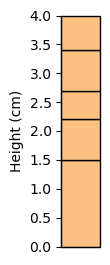

In [3]:
thicknesses = np.diff(units, axis=1).squeeze()
facies = np.array(['sand'] * len(thicknesses))

style = pystrat.Style(np.array(['sand']), 
                      np.array([[252, 193, 130]])/255, 
                      np.array([1]))
section = pystrat.Section(thicknesses, facies)
section.shift_heights(np.min(units[0]))   # make same y axis as heights

fig = plt.figure(figsize=(0.5, 3))
heights_ylim = [np.min(units[:, 0]), np.max(units[:, 1])]
ax = plt.axes(ylim=heights_ylim)
section.plot(style, ax=ax)
ax.set_ylabel('Height (cm)')
ax.set_xticks([])

plt.show()

## Synthetic geochronology

Create some temporal constraints within the core. Let's just put one at the top and bottom, and then randomly distribute some throughout.

For now, let's assume a constant uncertainty in temporal constraints. The "mean" values in time for each constraint will be sampled from normal distributions centered on the true values and with the same uncertainty specified below.

In [4]:
# temporal uncertainty
sig_t = 0.15

# number of constraints to include
n_constraints = 3

In [5]:
constraint_rvs = []
constraint_heights = []

# bottom (within first unit)
constraint_rvs.append(stats.norm(loc=stats.norm.rvs(loc=times[0, 0], scale=sig_t), scale=sig_t))
constraint_heights.append(0.1)
    
# top (within top unit)
constraint_rvs.append(stats.norm(loc=stats.norm.rvs(loc=times[-1, 1], scale=sig_t), scale=sig_t))
constraint_heights.append(3.9)

# 3rd constraint in middle
constraint_rvs.append(stats.norm(loc=stats.norm.rvs(loc=times[2, 1], scale=sig_t), scale=sig_t))
constraint_heights.append(2.5)

Now visualize the true age model alongside the constraints and the experimental stratigraphy.

In [6]:
t_plot = np.linspace(np.min(times) - 3*sig_t, np.max(times) + 3*sig_t, 400)

# true age model
t_true, z = stratage.age_depth(units, times)
# parameters for plotting pdfs
tol = 3
scale = 0.75

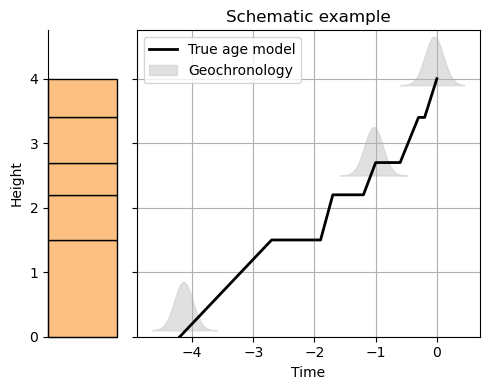

In [7]:
fig, ax = plt.subplots(1, 2, width_ratios=[1, 5], figsize=(5,4), sharey=True)

h = []
lab = []

ax[0].set_ylim([heights_ylim[0]-0.5, heights_ylim[1]+scale])
section.plot(style, ax=ax[0])
ax[0].set_xticks([])
ax[0].set_ylim([0, np.max(z)+scale])
ax[0].set_ylabel('Height')

cur_h = ax[1].plot(t_true, z, label='True age model', color='k', linewidth=2)[0]
h.append(cur_h)
lab.append('True age model')

for ii in range(n_constraints):
    cur_pdf = constraint_rvs[ii].pdf(t_plot)
    # only plot the part of the pdf that matters
    idx_pdf = np.log10(cur_pdf) > (np.max(np.log10(cur_pdf)) - tol)
    
    # scale it to be visible
    pdf_scale = scale/(np.max(cur_pdf[idx_pdf]) - np.min(cur_pdf[idx_pdf]))
    cur_pdf = constraint_heights[ii] + pdf_scale * cur_pdf
    
    cur_h = ax[1].fill_between(t_plot[idx_pdf], 
                             cur_pdf[idx_pdf],
                               constraint_heights[ii],
                               linewidth=1,
                               alpha=0.7,
                               color='lightgrey',
                               label='Geochronology')
h.append(cur_h)
lab.append('Geochronology')

ax[1].grid()
ax[1].set_xlabel('Time')
ax[1].legend(h, lab)
ax[1].set_title('Schematic example')

plt.tight_layout()

plt.show()

<div class="alert alert-block alert-info"> 
<b>NOTE</b> Geochronologic constraints must occur within units and not on contacts. Because hiatus exists at contacts, there would be ambiguity as to whether the constraint dates the "top" or "bottom" of the hiatus. 
</div>

We can use `stratage.geochron_height_check()` to ensure that the provided geochronologic constraints occur within the provided units and not on contacts. If nothing is returned, then we're good to go!

In [8]:
stratage.geochron_height_check(units, constraint_heights)

For now, age models can only be constructed in between the outermost geochronologic constraints. The upper and lower most units must therefore be "trimmed" such that the provided constraints bookend the entire stratigraphy perfectly.

The `stratage.trim_units()` function performs this trimming, which is plotted below, comparing the original stratigraphy on the left with the trimmed stratigraphy on the right.

In [9]:
units_trim = stratage.trim_units(units, constraint_heights)

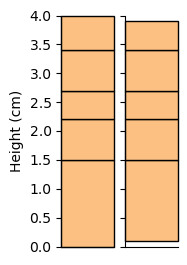

In [10]:
thicknesses_trim = np.diff(units_trim, axis=1).squeeze()

section_trim = pystrat.Section(thicknesses_trim, facies)
section_trim.shift_heights(np.min(units_trim[0]))   # make same y axis as heights

fig, ax = plt.subplots(1, 2, figsize=(1.5, 3), sharey=True)
ax[0].set_ylim(heights_ylim)
section.plot(style, ax=ax[0])
ax[0].set_ylabel('Height (cm)')
ax[0].set_xticks([])

section_trim.plot(style, ax=ax[1])
ax[1].set_xticks([])
ax[1].set_ylabel('')
plt.show()

## The `stratage.Geochron` class

The `Geochron` object constructed below contains the geochronologic constraints and their heights. It requires representation of the constraints as random variables with a `scipy.stats.distribution`-like signature; minimally providing `.pdf()` and `.ppf()` methods. The way we defined the constraints above will work perfectly.

Instantiation of the `Geochron` object creates a time increment distribution for every pair of geochronologic constraints. Each time increment distribution encodes the probability density of elapsed time between the given pair of constraints. 

For various reasons, the time increment distributions are evaluated numerically. At this time, a consistent temporal grid is used for all constraints. We can specify the resolution of this grid via the `dt` parameter when instantiating a `Geochron` object. Smaller values create finer grids, but require longer computation, especially for larger numbers of constraints.

In [11]:
geochron = Geochron(constraint_heights, constraint_rvs, 0.01, prob_threshold=1e-4, pair_method='nearest')

Constructing time increment pdfs:   0%|          | 0/2 [00:00<?, ?it/s]

Here we plot the time increment distributions using `Geochron.plot_increment_pdfs()`. The heights of the pairs of constraints for each time increment are labeled on the left side of the graph. From the principle of stratigraphic superposition, time increments are always positive.

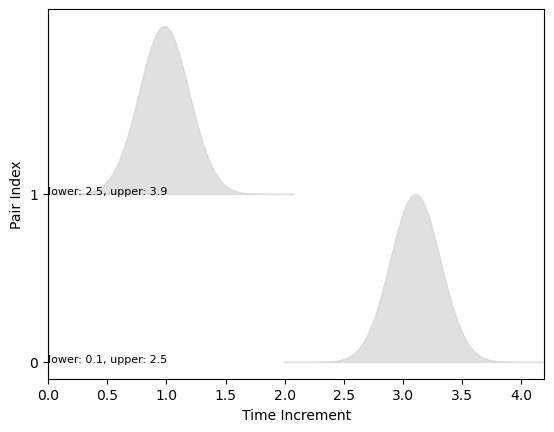

In [12]:
_ = geochron.plot_increment_pdfs()

## Least squares age-depth modeling

The `geochron.model_weights()` function generates the weights for units and contacts for each pair of constraints. These weights identify which contacts and units occur within a given pair of constraints. 

For contacts, the weights $\beta$ are either 0 or 1, because contacts cannot be partially bound by constraints.

For units, the weights $\alpha$ range from 0 to the thickness of the unit. A value equal to the thickness of the unit means that the given unit is completely bounded by a pair of constraints, i.e., no geochronologic constraint occurs within that unit. A value between 0 and the thickness of the unit means that for the given pair of constraints, one occurs within the unit, and the value of the weight quantifies the proportion of the unit that is bound between the constraints. This approach assumes a constant sedimentation rate for the portion of the unit that is partially bound by a constraint.

In [13]:
alpha, beta = geochron.model_weights(units_trim)

print(f'alpha:\n{alpha.T}\nbeta:\n{beta.T}')

alpha:
[[1.4 0.7 0.3 0.  0. ]
 [0.  0.  0.2 0.7 0.5]]
beta:
[[1. 1. 0. 0.]
 [0. 0. 1. 1.]]


The values of $\alpha$ and $\beta$ form arrays that define a linear system with respect to time increments:
$$
\begin{align}
\Delta \mathbf{T} &= \alpha\,\mathbf{v}^{-1} + \beta\,\mathbf{t} \\
         &= \begin{bmatrix}\alpha & \beta\end{bmatrix}\,\begin{bmatrix} \mathbf{v}^{-1} \\ \mathbf{t} \end{bmatrix} \\
         &= \mathbf{A}\,\mathbf{m}
\end{align}
$$

where $\Delta \mathbf{T}$ are the mean time increment values, $\mathbf{v}^{-1}$ is $1/v_{i}$ where $v_{i}$ is the sedimentation rate for each bed, and $\mathbf{t}$ are the hiatus durations between all beds.

As shown above, $\alpha$ and $\beta$ can be concatenated to form $\mathbf{A}$, and the system can be inverted via conventional least squares to solve for sedimentation rates $\mathbf{v}$ and hiatuses $\mathbf{t}$.

The `stratage.model_ls()` function performs this least squares inversion for the given units and geochronology. 

This function returns least squares estimates for sedimentation rates and hiatuses, but together these only constitute a floating age model. To anchor the age model with the given geochronology, we can use `stratage.fit_floating_model()`, which returns an array of the best fittings absolute ages (`times_bdls`) for each height in `units_trim`, given the geochronology and modeled sedimentation rates and hiatuses.

In [14]:
sed_rates_ls, hiatuses_ls = stratage.model_ls(units_trim, geochron)

# fit to constraints
times_bdls = stratage.fit_floating_model(sed_rates_ls, 
                                         hiatuses_ls, 
                                         units_trim, 
                                         geochron)
t_bdls, z_bdls = stratage.age_depth(units_trim, times_bdls)

Finally, we converted the paired `units_trim` and `times_bdls` arrays into a more straightforward pair of age-depth sequences using `stratage.age_depth()`.

Now, we can plot the least squares age-depth model alongside the true model and the geochronology.

Note that now that we have created the `Geochron` object, we can use the `Geochron.plot_constraints()` function to facilitate plotting the probability density functions for the contraints in an age-depth space.

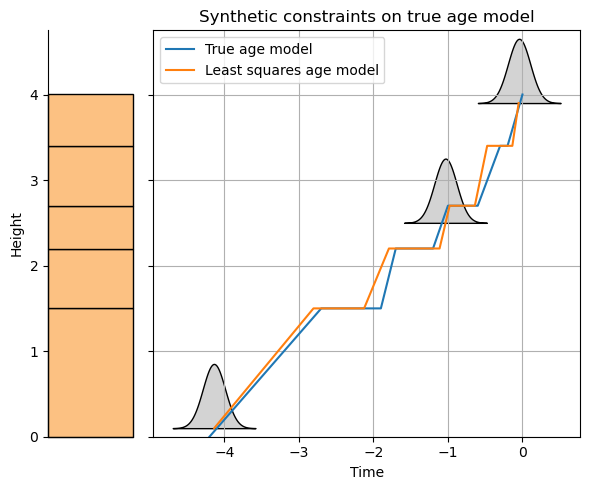

In [15]:
t_plot = np.linspace(np.min(times) - 3*sig_t, np.max(times) + 3*sig_t, 400)

# true age model
t_true, z = stratage.age_depth(units, times)
# parameters for plotting pdfs
tol = 3
scale = 0.75

fig, ax = plt.subplots(1, 2, width_ratios=[1, 5], figsize=(6,5), sharey=True)

ax[0].set_ylim([heights_ylim[0]-0.5, heights_ylim[1]+scale])
section.plot(style, ax=ax[0])
ax[0].set_xticks([])
ax[0].set_ylabel('Height')
ax[0].set_ylim([0, np.max(z)+scale])

ax[1].plot(t_true, z, label='True age model')
ax[1].plot(t_bdls, z_bdls, label='Least squares age model')

geochron.plot_constraints(ax=ax[1], scale=scale)

ax[1].grid()
ax[1].set_xlabel('Time')
ax[1].set_title('Synthetic constraints on true age model')
ax[1].legend()

plt.tight_layout()

plt.show()

The least-squares model generates a reasonable age model that passes through the maximum likelihood values of the geochronologic constraints. `StratAge` uses the least squares solution as the initial model for the Markov Chain sampling.

## `StratAge.AgeModel`

To set up the Bayesian model, we must specify prior distributions over sedimentation rates and hiatus durations. These distributions must be defined as functions that have the signature that is expected for the `dist` argument in [`pymc.CustomDist(dist=dist)`](https://www.pymc.io/projects/docs/en/v5.14.0/api/distributions/generated/pymc.CustomDist.html), i.e. a signature of `dist(*dist_params, size)`. At this time, `StrageAge` cannot sample from hierarchical priors, meaning that prior distributions cannot require any `dist_params`. Therefore, the expected signature for prior distributions is just `prior(size)`.

Below, we use a log-normal prior over sedimentation rates, with a sigma of 1.2. We use a log-uniform prior over hiatus durations, ranging from 0.1 to 10. Notice that we are using `PyMC` distributions; any of the `PyMC` distributions should work analagously to what is shown below.

In [16]:
# all units have same sed rate prior
sed_rate_sigma = 1.2*np.ones(n_units)

def sed_rates_prior_fn(size):
    return pm.LogNormal.dist(sigma=sed_rate_sigma, size=size)

def hiatuses_prior_fn(size):
    return 10**pm.Uniform.dist(lower=-1, upper=1, size=size)

Note that if you wanted to have different parameter values for the priors on different beds or contacts, then you could just need to specify arrays accordingly. For example, if we wanted the first bed to have a narrower prior distribution of sedimentation rates, we could have defined `sed_rate_sigma` as follows:
```python
sed_rate_sigma = 1.2*np.ones(n_units)
sed_rate_sigma[0] = 0.5
```

Now that we have both prior distributions and the `Geochron` object with the probabilistic geochronologic constraints, we can instantiate the `stratage.AgeModel` class.

In [17]:
agemodel = stratage.AgeModel(units, geochron, sed_rates_prior_fn, hiatuses_prior_fn)

This class creates an object with a `pymc.Model` as an attribute, which we can visualize.

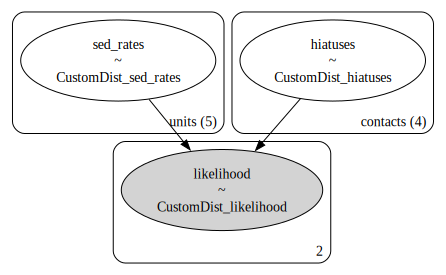

In [18]:
pm.model_to_graphviz(agemodel.model)

The model visualization shows that we have a random variable of sedimentation rates with a length of 5 and a random variable of hiatuses with a length of 4. The coordinates for these random variables are named "units" and "contacts," and the sizes make sense with our simple stratigraphy that has 5 units and 4 contacts. We also see that these random varialbes are sampled according to `CustomDist` distributions, which correspond to the priors we defined above.

These random variables feed into a likelihood, which has a length of 3. This size reflects the 3 time increment distributions from the 3 unique combinations of geochronologic constraints, which were plotted above. The likelihood is based on the time increment distributions from the 3 pairs of constraints, defining the `CustomDist_likelihood` in the diagram above. 

With the model defined above, we can use all the helpful and robust `PyMC` sampling tools. For example, we can sample from the prior distributions on sedimentation rates and hiatuses to see what sort of age models we would get.

In [19]:
times_prior = agemodel.sample_prior(draws=100)

Sampling: [hiatuses, likelihood, sed_rates]


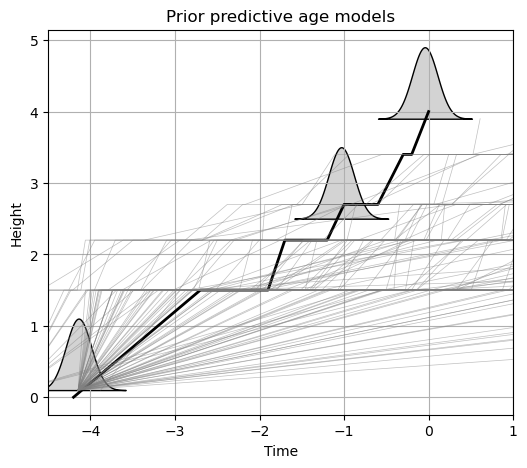

In [20]:
# true age model
t_true, z_true = stratage.age_depth(units, times)
# parameters for plotting pdfs
tol = 3
scale = 1

fig = plt.figure(figsize=(6,5))
ax = plt.axes()

# true age model and constraints
geochron.plot_constraints(ax=ax)
ax.plot(t_true, z_true, label='true age model', linewidth=2, color='k')

# prior predictive models
for ii in range(len(times_prior)):
    cur_t, cur_z = stratage.age_depth(units_trim, times_prior[ii])
    plt.plot(cur_t, cur_z, color='gray', linewidth=0.5, alpha=0.5)

ax.grid()
ax.set_xlabel('Time')
ax.set_ylabel('Height')
ax.set_title('Prior predictive age models')

ax.set_xlim([-4.5, 1])

plt.show()

The prior predictive models are not very good, as we can see in the figure above.

Let's now actually sample the Bayesian age model. We do so by invoking `stratage.AgeModel.sample()`, which accepts keyword arguments that are passed to `pymc.sample()`.

At this time, sampling is restricted to the conventional Metropolis sampler.

In [21]:
draws = 5000
tune = 2000
n_chains = 4

trace = agemodel.sample(draws=draws, tune=tune, chains=n_chains)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sed_rates]
>Metropolis: [hiatuses]


Output()

Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 90 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


We can use `arviz` to tabulate and plot helpful diagnostics for the chains that we sampled above.

In [22]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
hiatuses[0],0.688,0.566,0.100,1.787,0.044,0.031,191.0,301.0,1.03
hiatuses[1],0.614,0.520,0.100,1.616,0.033,0.023,270.0,556.0,1.02
hiatuses[2],0.241,0.138,0.100,0.499,0.004,0.003,1203.0,1315.0,1.00
hiatuses[3],0.242,0.137,0.100,0.498,0.003,0.002,1449.0,1411.0,1.00
sed_rates[0],2.472,2.461,0.522,6.538,0.153,0.108,184.0,174.0,1.01
sed_rates[1],2.179,2.402,0.294,6.423,0.131,0.093,243.0,218.0,1.01
sed_rates[2],3.024,3.176,0.282,8.813,0.127,0.094,745.0,936.0,1.01
sed_rates[3],4.623,4.453,0.772,11.874,0.176,0.137,1046.0,939.0,1.00
sed_rates[4],4.117,4.259,0.532,11.636,0.156,0.110,967.0,933.0,1.00


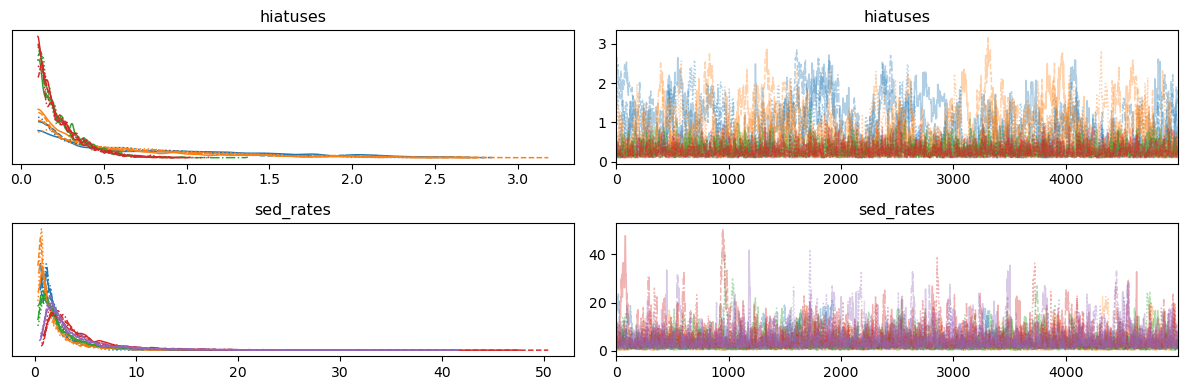

In [23]:
az.plot_trace(trace)
plt.tight_layout()
plt.show()

## Generating age models

`StratAge.AgeModel` implements a Bayesian model to generate samples of sedimentation rates and hiatuses, but, as mentioned above, these only yield floating age models by themselves. Sedimentation rates and hiatuses in the trace generated by the PyMC sampling can be aligned to the geochronology using the `StratAge.AgeModel.trace2ages()` function. 

This function returns posterior ages at requested stratigraphic heights. Note that this can take some time but is easily parallelized, so you can increase the `n_jobs` parameter to use more processes for large traces.

In [24]:
n_h = 500
h = np.linspace(np.min(units_trim), np.max(units_trim), n_h)

t_posterior = agemodel.trace2ages(trace, h=h, n_jobs=4)

Anchoring floating age models:   0%|          | 0/10000 [00:00<?, ?it/s]

In [25]:
ci_95 = np.quantile(t_posterior, [0.025, 0.975], axis=0)
ci_68 = np.quantile(t_posterior, [0.16, 0.84], axis=0)

We can evaluate quantiles on the posterior age models and finally plot the Bayesian age model.

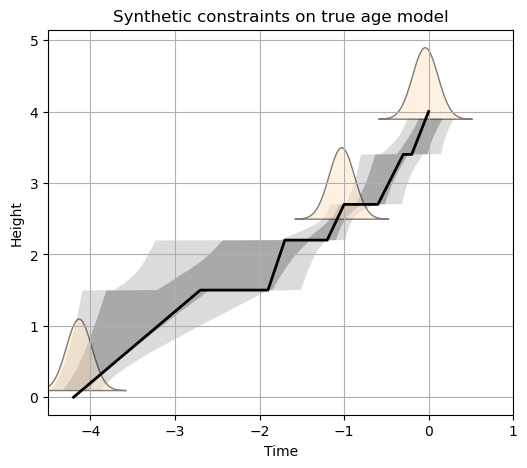

In [26]:
# true age model
t_true, z_true = stratage.age_depth(units, times)
# parameters for plotting pdfs
tol = 3
scale = 1

fig = plt.figure(figsize=(6,5))
ax = plt.axes()

# posterior predictive models
ax.fill_betweenx(h, ci_95[0, :], ci_95[1, :], facecolor='gainsboro')
ax.fill_betweenx(h, ci_68[0, :], ci_68[1, :], facecolor='darkgrey')

# true age model and constraints
geochron.plot_constraints(ax=ax, facecolor='bisque', alpha=0.5)
ax.plot(t_true, z_true, label='true age model', linewidth=2, color='k')

ax.grid()
ax.set_xlabel('Time')
ax.set_ylabel('Height')
ax.set_title('Synthetic constraints on true age model')

ax.set_xlim([-4.5, 1])

plt.show()

Here we can see how the structure of the posterior age model is distinctly different from existing age modeling approaches. The envelope shows "jumpiness" that reflects the possibility of hiatus at bedding contacts. 